In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np; import pandas as pd
import psycopg2, psycopg2.extras, psycopg2.pool, pickle, json, matplotlib, sys, time
from multiprocessing import Pool, Manager
from collections import OrderedDict
from sqlalchemy import create_engine
import seaborn as sns
%matplotlib inline

# Contributor Density
Since each tile varies in area depending on it's latitude, we have processed each tile at the per-km level. The results are stored in the `users-per-sqkm` database.

This notebook connects to this database and then tracks individual users present each year on each square kilometer inside of each tile.

It takes the _average per year_ for these, and tracks the _running average_ (while maintaining unique users).

### Connect to the `users-per-sqkm` database

In [2]:
d = "dbname=users-per-sqkm user=anderstj host=127.0.0.1"
conn1 = psycopg2.pool.ThreadedConnectionPool(1, 50, dsn=d)
CURSOR = conn1.getconn().cursor( cursor_factory = psycopg2.extras.DictCursor)

In [3]:
def get_year_data(year, quad):
    string = "SELECT * FROM tiles_per_year_%s "%(year)
    CURSOR.execute(string + "where quadkey = %s",(quad,))
    return CURSOR.fetchall()

In [4]:
def get_annual_averages(quadkey,idx):
    quad_sections  = {}
    years          = []
    sys.stderr.write("\r"+str(idx)+": "+quadkey)

    for year in [2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016]:
        sys.stderr.write(".")
        res_coll = get_year_data(year, quadkey)
        this_year = {'year':year}#, 'annual_mappers_per_sq_km':[]}
        for res in res_coll:
            qa = res[3]            
#             this_year['annual_mappers_per_sq_km'].append(len(np.unique(res[5])) / res[4] )

            section_id = res[2]

            if section_id in quad_sections: 
                quad_sections[section_id]['users']+= res[5]
            else:
                quad_sections[section_id] = {'users':res[5], 'a':res[4]} 
        #Within each year, get the running average as it counts the users
        running_avg = []
        users = []
        for a, data in quad_sections.items():
            users_per_sqkm = len(np.unique(data['users'])) / data['a']
            running_avg.append(users_per_sqkm)
            users += data['users']
        
        this_year['running_average'] = np.average(running_avg)
#         this_year['annual_average']  = np.average(this_year['annual_mappers_per_sq_km'])
#         this_year['unique_users']    = len(np.unique(users))

        years.append(this_year)
        
    return(years[-1]['running_average'])
        
#     df = pd.DataFrame(years)
#     df['tile_area'] = qa
#     df['users_over_area'] = df.unique_users / df.tile_area
    return df

In [5]:
#List of quadkeys...
all_quads = pd.read_sql_query("""SELECT DISTINCT(quadkey) FROM tiles_per_year""", con=create_engine("postgresql://anderstj@127.0.0.1:5432/osm-quality-full-v3"))

In [7]:
print(len(all_quads))

3249936


In [12]:
all_quads['users_per_sqkm'] = np.NaN
all_quads.query('users_per_sqkm>15')

,quadkey,users_per_sqkm


In [24]:
section = all_quads.head(100000).copy()

In [25]:
section['users_per_sqkm'] = section.apply(lambda row: get_annual_averages(row.quadkey, row.name), axis=1)

0: 001311103030./usr/local/lib/python3.4/dist-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
99999: 003203101001............

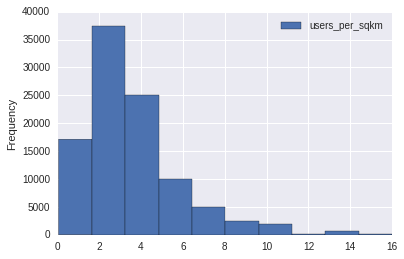

In [30]:
section.plot(kind='hist')

In [37]:
len(section.query('users_per_sqkm>=15'))

7

In [38]:
section2 = all_quads.iloc[100000:1000000].copy()

In [ ]:
section2['users_per_sqkm'] = section2.apply(lambda row: get_annual_averages(row.quadkey, row.name), axis=1)

100000: 003203101002./usr/local/lib/python3.4/dist-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
834165: 032233110022.........

In [ ]:
section3 = all_quads.iloc[1000001:2000000].copy()

In [43]:
section2.query("users_per_sqkm >= 15").count()

quadkey           9248
users_per_sqkm    9248
dtype: int64

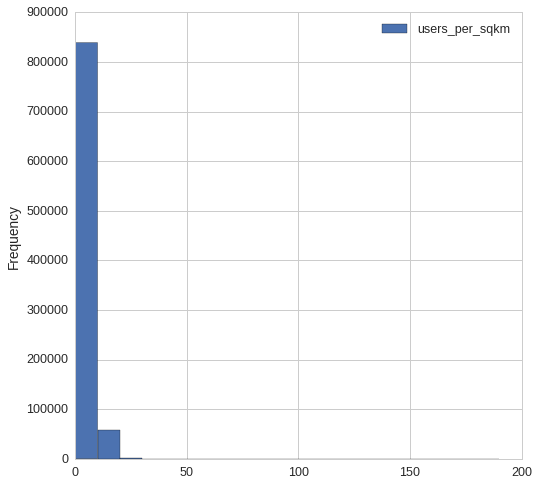

In [44]:
sns.set(font_scale=1.25)
plt.style.use('seaborn-whitegrid')
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8,8), facecolor='w', edgecolor='k')
plt.subplots_adjust(wspace=0.25, hspace=0.3)

section2.plot(ax=axs, kind='hist')